##Librerias

In [1]:
!pip install tensorflow
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
# tf.python.control_flow_ops = tf #esta línea evita un conflicto entre Keras y Tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from scikeras.wrappers import KerasClassifier


import sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import   OneHotEncoder, StandardScaler



In [5]:
from tensorflow.python.client import device_lib

def gpuon():
    local_device_protos = device_lib.list_local_devices()
    print([x.name for x in local_device_protos if x.device_type == 'GPU'])

gpuon()

['/device:GPU:0']


In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan  9 08:07:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    28W /  70W |    312MiB / 15109MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


##Carga de datos

In [8]:
df_sin_movilidad = pd.read_csv("/content/drive/MyDrive/TFM/datos/df_sin_movilidad.csv", sep = ";")

In [9]:
df_sin_movilidad.index = df_sin_movilidad.fecha  ##Set_index('fecha')
df_sin_movilidad = df_sin_movilidad.drop('fecha', axis=1)
df_sin_movilidad

,indicativo,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,...,alto_riesgo,peligro,vulner,ocurrencia,municipio,cod_municipio,laborable,dayofyear,weekend,mes
fecha,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0002I,0.0,12.4,12.1,11.9,0.3,8.3,457.0,1020.7,1020.1,...,Sí,Molt Alt,Molt Alta,0,Vandellos l’Hospitalet de l’Infant,43162,3,1,0,1
2015-01-01,WE,0.0,11.3,11.1,10.7,5.3,7.8,449.0,1027.2,1021.7,...,Sí,Alt,Molt Alta,0,Vilanova del Vallès,8946,3,1,0,1
2015-01-01,WG,0.0,8.5,8.1,7.6,0.8,2.3,428.0,1020.0,1019.6,...,Sí,Molt Alt,Moderada,0,Algerri,25528,3,1,0,1
2015-01-01,WI,0.0,7.8,7.6,7.4,2.1,4.1,468.0,1031.5,1031.3,...,Sí,Molt Alt,Baixa,0,Maials,25761,3,1,0,1
2015-01-01,WJ,0.0,12.3,11.7,11.3,1.0,2.4,449.0,1000.2,999.7,...,Sí,Molt Alt,Moderada,0,El Masroig,43675,3,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,UN,0.0,14.8,14.3,14.0,1.4,3.5,526.0,954.0,953.8,...,Sí,Alt,Alta,0,Cassà de la Selva,17462,1,32,0,2
2022-02-01,UO,0.0,14.0,13.7,13.3,5.5,10.2,574.0,1023.8,1023.4,...,Sí,Exclos,Moderada,0,Fornells de la Selva,17466,1,32,0,2
2022-02-01,UP,0.0,13.6,13.3,13.1,2.2,4.3,544.0,1013.9,1013.6,...,Sí,Exclos,Molt Alta,0,Cabrils,8489,1,32,0,2


In [10]:
df_sin_movilidad.shape

(488345, 23)

#1.1 Division de datos
---



In [11]:
df_train = df_sin_movilidad.loc['2015-01-01':'2020-12-31'] # 6 años de train
df_test = df_sin_movilidad.loc['2021-01-01':'2022-12-31']  # 1 año y medio de test

In [12]:
X_train = df_train.drop('ocurrencia', axis=1)
y_train = df_train['ocurrencia']

X_test = df_test.drop('ocurrencia', axis=1)
y_test = df_test['ocurrencia']

In [13]:
df_sin_movilidad.shape, df_train.shape,  X_train.shape, y_train.shape, df_test.shape, X_test.shape, y_test.shape

((488345, 23),
 (413052, 23),
 (413052, 22),
 (413052,),
 (75293, 23),
 (75293, 22),
 (75293,))

#1.2 Normalización

In [14]:
# normalizacion de los datos numericos
from sklearn.preprocessing import StandardScaler
numericalCols_train = df_train[["prec", "tmax",  "tmed",  "tmin",  "velmedia",  "racha",  "sol",  "presMax",  "presMin",  "rhum",  "altitud", "porcentaje_pendiente_total" ]] 
numericalCols_test = df_test[["prec", "tmax",  "tmed",  "tmin",  "velmedia",  "racha",  "sol",  "presMax",  "presMin",  "rhum",  "altitud", "porcentaje_pendiente_total" ]] 
scaler = StandardScaler()
scaler.fit(numericalCols_train)

numericalCols_train_scaled = scaler.transform(numericalCols_train)
numericalCols_test_scaled = scaler.transform(numericalCols_test)

numericalCols_train_scaled.shape , numericalCols_test_scaled.shape

((413052, 12), (75293, 12))

In [15]:
# normalizacion de los datos categoricos , sin la ocurrencia
from sklearn.preprocessing import OneHotEncoder
categoricalCols_train = df_train[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	vulner
categoricalCols_train = OneHotEncoder().fit_transform(categoricalCols_train).toarray()


# normalizacion de los datos categoricos , sin la ocurrencia
from sklearn.preprocessing import OneHotEncoder
categoricalCols_test = df_test[['alto_riesgo',	'peligro',	'vulner']]   #alto_riesgo	peligro	 y vulner
categoricalCols_test = OneHotEncoder().fit_transform(categoricalCols_test).toarray()

categoricalCols_train.shape, categoricalCols_test.shape

((413052, 12), (75293, 12))

In [16]:
Other_var_train = df_train[['laborable', 	'dayofyear', 	'weekend', 	'mes']]
Other_var_test = df_test[['laborable', 	'dayofyear', 	'weekend', 	'mes']]  #alto_riesgo	peligro	 y vulner

In [17]:
df_train_scaled = np.concatenate((numericalCols_train_scaled , categoricalCols_train, Other_var_train), axis=1)
df_test_scaled = np.concatenate((numericalCols_test_scaled , categoricalCols_test, Other_var_test), axis=1)
df_train_scaled.shape, df_test_scaled.shape

((413052, 28), (75293, 28))

In [18]:
X_test = df_test_scaled
X_train = df_train_scaled

# 1.3. Model LSTM (df_all_sin_mov)

Vamos a generar una LSTM con dos capas

1. LSTM - Es la capa que trabaja en la clasificación. Donde se indica el numero de neuronas
2. Capa de dropout (apagado de neuronas)
3. Capa de activacion sigmoide ya que estamos ante una clasificación biaria (0-1)
4. Una única neurona de salida con un sigmoide

In [19]:
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import InputLayer

def modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 32):
    model=Sequential()
    model.add(InputLayer((28,1)))
    model.add(LSTM(n_lstm))
    model.add(Dropout(dropout_rate))
    model.add(Dense(28, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [20]:
model = modelLSTM()

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 28)                5628      
                                                                 
 dropout_1 (Dropout)         (None, 28)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 29        
                                                                 
Total params: 167,257
Trainable params: 167,257
Non-trainable params: 0
_________________________________________________________________


In [22]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=3, patience=10)

model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20, callbacks=[cp, earlyStop])

Epoch 1/20
12905/12908 [============================>.] - ETA: 0s - loss: 0.0391 - accuracy: 0.9938

12908/12908 [==============================] - 78s 6ms/step - loss: 0.0391 - accuracy: 0.9938 - val_loss: 0.0428 - val_accuracy: 0.9929
Epoch 2/20
12907/12908 [============================>.] - ETA: 0s - loss: 0.0381 - accuracy: 0.9940

12908/12908 [==============================] - 68s 5ms/step - loss: 0.0381 - accuracy: 0.9940 - val_loss: 0.0425 - val_accuracy: 0.9929
Epoch 3/20
12908/12908 [==============================] - 64s 5ms/step - loss: 0.0378 - accuracy: 0.9940 - val_loss: 0.0425 - val_accuracy: 0.9929
Epoch 4/20
12908/12908 [==============================] - 63s 5ms/step - loss: 0.0374 - accuracy: 0.9940 - val_loss: 0.0426 - val_accuracy: 0.9929
Epoch 5/20
12908/12908 [==============================] - 63s 5ms/step - loss: 0.0374 - accuracy: 0.9940 - val_loss: 0.0431 - val_accuracy: 0.9929
Epoch 6/20
12908/12908 [==============================] - 64s 5ms/step - loss: 0.0370 - accuracy: 0.9940 - val_loss: 0.0428 - val_accuracy: 0.9929
Epoch 7/20
12900/12908 [============================>.] - ETA: 0s - loss: 0.0366 - accuracy: 0.9940

12908/12908 [==============================] - 67s 5ms/step - loss: 0.0366 - accuracy: 0.9940 - val_loss: 0.0414 - val_accuracy: 0.9929
Epoch 8/20
12906/12908 [============================>.] - ETA: 0s - loss: 0.0365 - accuracy: 0.9940

12908/12908 [==============================] - 67s 5ms/step - loss: 0.0365 - accuracy: 0.9940 - val_loss: 0.0409 - val_accuracy: 0.9929
Epoch 9/20
12908/12908 [==============================] - 64s 5ms/step - loss: 0.0365 - accuracy: 0.9940 - val_loss: 0.0411 - val_accuracy: 0.9929
Epoch 10/20
12900/12908 [============================>.] - ETA: 0s - loss: 0.0361 - accuracy: 0.9940

12908/12908 [==============================] - 67s 5ms/step - loss: 0.0361 - accuracy: 0.9940 - val_loss: 0.0408 - val_accuracy: 0.9929
Epoch 11/20
12908/12908 [==============================] - 64s 5ms/step - loss: 0.0360 - accuracy: 0.9940 - val_loss: 0.0411 - val_accuracy: 0.9929
Epoch 12/20
12908/12908 [==============================] - 64s 5ms/step - loss: 0.0363 - accuracy: 0.9940 - val_loss: 0.0408 - val_accuracy: 0.9929
Epoch 13/20
12908/12908 [==============================] - 64s 5ms/step - loss: 0.0359 - accuracy: 0.9940 - val_loss: 0.0413 - val_accuracy: 0.9929
Epoch 14/20
12900/12908 [============================>.] - ETA: 0s - loss: 0.0361 - accuracy: 0.9940

12908/12908 [==============================] - 67s 5ms/step - loss: 0.0361 - accuracy: 0.9940 - val_loss: 0.0408 - val_accuracy: 0.9929
Epoch 15/20
12908/12908 [==============================] - 64s 5ms/step - loss: 0.0360 - accuracy: 0.9940 - val_loss: 0.0412 - val_accuracy: 0.9929
Epoch 16/20
12904/12908 [============================>.] - ETA: 0s - loss: 0.0360 - accuracy: 0.9940

12908/12908 [==============================] - 67s 5ms/step - loss: 0.0360 - accuracy: 0.9940 - val_loss: 0.0406 - val_accuracy: 0.9929
Epoch 17/20
12901/12908 [============================>.] - ETA: 0s - loss: 0.0357 - accuracy: 0.9940

12908/12908 [==============================] - 68s 5ms/step - loss: 0.0357 - accuracy: 0.9940 - val_loss: 0.0404 - val_accuracy: 0.9929
Epoch 18/20
12907/12908 [============================>.] - ETA: 0s - loss: 0.0355 - accuracy: 0.9940

12908/12908 [==============================] - 68s 5ms/step - loss: 0.0355 - accuracy: 0.9940 - val_loss: 0.0403 - val_accuracy: 0.9929
Epoch 19/20
12908/12908 [==============================] - 64s 5ms/step - loss: 0.0356 - accuracy: 0.9940 - val_loss: 0.0412 - val_accuracy: 0.9929
Epoch 20/20
12908/12908 [==============================] - 64s 5ms/step - loss: 0.0355 - accuracy: 0.9940 - val_loss: 0.0405 - val_accuracy: 0.9929


In [23]:
scores = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

2353/2353 - 5s - loss: 0.0405 - accuracy: 0.9929 - 5s/epoch - 2ms/step
accuracy: 99.29%


In [24]:
y_pred_model_1 = model.predict(X_test)

2353/2353 [==============================] - 5s 2ms/step


In [25]:
# print classification report
y_pred_model1 = np.argmax(y_pred_model_1, axis=1)
print(classification_report(y_test, y_pred_model1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     74755
           1       0.00      0.00      0.00       538

    accuracy                           0.99     75293
   macro avg       0.50      0.50      0.50     75293
weighted avg       0.99      0.99      0.99     75293



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[74755     0]
 [  538     0]]


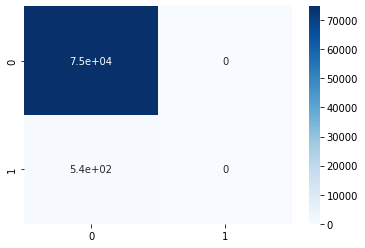

In [26]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

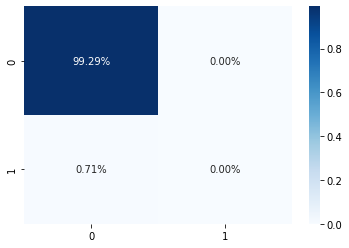

In [27]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

#Division de datos (UnderSampler Manual)

In [28]:
df_sin_mov = df_sin_movilidad.loc['2015-01-01':'2022-12-31']

In [29]:
df_sin_movilidad.groupby("ocurrencia").count()

,indicativo,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,...,porcentaje_pendiente_total,alto_riesgo,peligro,vulner,municipio,cod_municipio,laborable,dayofyear,weekend,mes
ocurrencia,,,,,,,,,,,,,,,,,,,,,
0,485316,485316,485316,485316,485316,485316,485316,485316,485316,485316,...,485316,485316,485316,485316,485316,485316,485316,485316,485316,485316
1,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029,...,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029


In [30]:
df_sin_movilidad.groupby("ocurrencia").count().columns

Index(['indicativo', 'prec', 'tmax', 'tmed', 'tmin', 'velmedia', 'racha',
       'sol', 'presMax', 'presMin', 'rhum', 'altitud',
       'porcentaje_pendiente_total', 'alto_riesgo', 'peligro', 'vulner',
       'municipio', 'cod_municipio', 'laborable', 'dayofyear', 'weekend',
       'mes'],
      dtype='object')

In [31]:
df_ocurrencia_0 = df_sin_movilidad[df_sin_movilidad["ocurrencia"]==0].sample(3029)

In [32]:
df_ocurrencia_1 = df_sin_movilidad[df_sin_movilidad["ocurrencia"]==1]

In [33]:
df_sin_movilidad =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])
df_sin_movilidad.shape

(6058, 23)

In [34]:
x = df_sin_movilidad['indicativo'].unique()
len(x)

197

In [35]:
X = df_sin_movilidad.drop( ['ocurrencia', 'municipio', 'cod_municipio', 'indicativo'], axis=1)
y = df_sin_movilidad['ocurrencia']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train

,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,rhum,altitud,porcentaje_pendiente_total,alto_riesgo,peligro,vulner,laborable,dayofyear,weekend,mes
fecha,,,,,,,,,,,,,,,,,,,
2016-06-30,0.0,30.5,29.6,28.9,4.4,5.3,960.0,985.0,984.6,55.0,142.0,5.20,Sí,Molt Alt,Mitja,3,182,0,6
2019-08-09,0.0,32.6,32.1,31.2,5.4,7.7,939.0,1009.8,1009.6,37.0,843.0,3.22,Sí,Alt,Molt Alta,4,221,0,8
2020-08-21,0.0,34.0,33.5,32.8,3.9,6.1,796.0,993.0,992.8,41.0,207.0,2.90,Sí,Moderat,Moderada,4,234,0,8
2017-02-13,1.7,9.5,9.4,9.3,1.6,5.7,20.0,913.3,912.9,100.0,399.0,1.70,Sí,Alt,Molt Alta,0,44,0,2
2021-01-01,0.0,9.8,9.7,9.5,5.8,11.0,308.0,1005.1,1004.9,57.0,11.0,3.50,Sí,Alt,Baixa,4,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-06,2.0,14.0,9.2,4.4,2.2,8.1,0.0,980.8,970.9,94.0,277.0,3.22,Sí,Alt,Mitja,2,65,0,3
2019-03-06,0.0,16.0,15.4,15.2,0.9,2.9,173.0,1001.4,1000.8,83.0,87.0,1.70,Sí,Molt Alt,Molt Alta,2,65,0,3
2019-03-07,0.0,13.9,13.4,13.0,2.1,5.7,745.0,935.4,935.0,43.0,376.0,2.80,Sí,Molt Alt,Moderada,3,66,0,3


# 1.2. Normalizacion datos



In [37]:
# normalizacion de los datos numericos
numericalCols_train = X_train[["prec", "tmax",  "tmed",  "tmin",  "velmedia",  "racha",  "sol",  "presMax",  "presMin",  "rhum",  "altitud", "porcentaje_pendiente_total" ]]  
numericalCols_test = X_test[["prec", "tmax",  "tmed",  "tmin",  "velmedia",  "racha",  "sol",  "presMax",  "presMin",  "rhum",  "altitud", "porcentaje_pendiente_total" ]]  

scaler = StandardScaler()
scaler.fit(numericalCols_train)

numericalCols_train_scaled = scaler.transform(numericalCols_train)
numericalCols_test_scaled = scaler.transform(numericalCols_test)

numericalCols_train_scaled.shape , numericalCols_test_scaled.shape

((4846, 12), (1212, 12))

In [38]:
# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_train = X_train[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	vulner
categoricalCols_train = OneHotEncoder().fit_transform(categoricalCols_train).toarray()

# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_test = X_test[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	 y vulner
categoricalCols_test = OneHotEncoder().fit_transform(categoricalCols_test).toarray()

categoricalCols_train.shape, categoricalCols_test.shape

((4846, 12), (1212, 12))

In [39]:
Other_var_train = X_train[['laborable', 	'dayofyear', 	'weekend', 	'mes']]
Other_var_test = X_test[['laborable', 	'dayofyear', 	'weekend', 	'mes']]  #alto_riesgo	peligro	 y vulner

In [40]:
df_train_scaled = np.concatenate((numericalCols_train_scaled , categoricalCols_train, Other_var_train), axis=1)
df_test_scaled = np.concatenate((numericalCols_test_scaled , categoricalCols_test, Other_var_test), axis=1)

In [41]:
df_train_scaled.shape, y_train.shape, df_test_scaled.shape, y_test.shape

((4846, 28), (4846,), (1212, 28), (1212,))

In [42]:
X_train = df_train_scaled.reshape(df_train_scaled.shape[0],df_train_scaled.shape[1],1)
X_train.shape, y_train.shape

((4846, 28, 1), (4846,))

In [43]:
X_test = df_test_scaled.reshape(df_test_scaled.shape[0],df_test_scaled.shape[1],1)
X_test.shape, y_test.shape

((1212, 28, 1), (1212,))

# 1.3. Model LSTM (df_all_sin_mov -  UnderSampling Manual)

Vamos a generar una LSTM con dos capas

1. LSTM - Es la capa que trabaja en la clasificación. Donde se indica el numero de neuronas
2. Capa de dropout (apagado de neuronas)
3. Capa de activacion sigmoide ya que estamos ante una clasificación biaria (0-1)
4. Una única neurona de salida con un sigmoide

In [44]:
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import InputLayer

def modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 32):
    model=Sequential()
    model.add(InputLayer((28,1)))
    model.add(LSTM(n_lstm))
    model.add(Dropout(dropout_rate))
    model.add(Dense(28, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [221]:
model = modelLSTM()

In [222]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 200)               161600    
                                                                 
 dropout_30 (Dropout)        (None, 200)               0         
                                                                 
 dense_30 (Dense)            (None, 28)                5628      
                                                                 
 dropout_31 (Dropout)        (None, 28)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 29        
                                                                 
Total params: 167,257
Trainable params: 167,257
Non-trainable params: 0
_________________________________________________________________


In [223]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=3, patience=10)

model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20, callbacks=[cp, earlyStop])

Epoch 1/20
152/152 [==============================] - ETA: 0s - loss: 0.6603 - accuracy: 0.6174

152/152 [==============================] - 7s 39ms/step - loss: 0.6603 - accuracy: 0.6174 - val_loss: 0.8845 - val_accuracy: 0.3919
Epoch 2/20
148/152 [============================>.] - ETA: 0s - loss: 0.6305 - accuracy: 0.6415

152/152 [==============================] - 5s 31ms/step - loss: 0.6305 - accuracy: 0.6434 - val_loss: 0.8805 - val_accuracy: 0.5330
Epoch 3/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6109 - accuracy: 0.6529 - val_loss: 0.9483 - val_accuracy: 0.5107
Epoch 4/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6155 - accuracy: 0.6500 - val_loss: 0.9529 - val_accuracy: 0.4686
Epoch 5/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6143 - accuracy: 0.6529 - val_loss: 0.9275 - val_accuracy: 0.2071
Epoch 6/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6104 - accuracy: 0.6515 - val_loss: 1.0089 - val_accuracy: 0.4356
Epoch 7/20
144/152 [===========================>..] - ETA: 0s - loss: 0.6085 - accuracy: 0.6641

152/152 [==============================] - 5s 30ms/step - loss: 0.6064 - accuracy: 0.6667 - val_loss: 0.7795 - val_accuracy: 0.5825
Epoch 8/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6130 - accuracy: 0.6554 - val_loss: 0.8822 - val_accuracy: 0.3465
Epoch 9/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6079 - accuracy: 0.6546 - val_loss: 0.8394 - val_accuracy: 0.4356
Epoch 10/20
152/152 [==============================] - 1s 7ms/step - loss: 0.6083 - accuracy: 0.6674 - val_loss: 0.9239 - val_accuracy: 0.4266
Epoch 11/20
152/152 [==============================] - 1s 7ms/step - loss: 0.6065 - accuracy: 0.6599 - val_loss: 0.8953 - val_accuracy: 0.1064
Epoch 12/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6045 - accuracy: 0.6659 - val_loss: 1.0174 - val_accuracy: 0.4422
Epoch 13/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6080 - accuracy: 0.6610 - val_loss: 0.9458 - val_accuracy: 0.3135
Epoch 14/20


In [224]:
scores = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

38/38 - 0s - loss: 0.9955 - accuracy: 0.2970 - 100ms/epoch - 3ms/step
accuracy: 29.70%


In [225]:
y_pred_model_1 = model.predict(X_test)

38/38 [==============================] - 0s 2ms/step


In [226]:
# print classification report
y_pred_model1 = np.argmax(y_pred_model_1, axis=1)
print(classification_report(y_test, y_pred_model1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    1212.0

    accuracy                           0.00    1212.0
   macro avg       0.00      0.00      0.00    1212.0
weighted avg       0.00      0.00      0.00    1212.0



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

[[   0    0]
 [1212    0]]


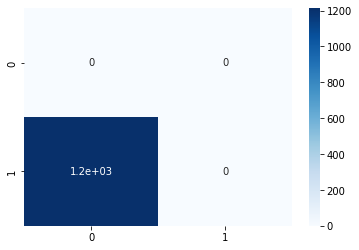

In [227]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

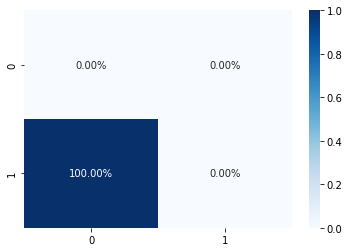

In [228]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# 1.3.1 GridSearch -  Modelo LSTM con division manual (X_train y_train)

In [ ]:
!pip install scikeras

In [ ]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
final_model = grid_result.best_estimator_
final_model

In [ ]:
y_pred = final_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
y_pred = (final_model.predict_proba(X_test)[:,1] >= 0.51).astype(bool)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

# 1.4. Model LSTM clases balanceadas con SMOTE

In [229]:
from imblearn.over_sampling import SMOTE 
X_smote , y_smote = SMOTE().fit_resample( df_train_scaled, y_train)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_smote.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_smote.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_smote == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_smote == 0)))

Before OverSampling, counts of label '1': 1817
Before OverSampling, counts of label '0': 3029 

After OverSampling, the shape of train_X: (6058, 28)
After OverSampling, the shape of train_y: (6058,) 

After OverSampling, counts of label '1': 3029
After OverSampling, counts of label '0': 3029


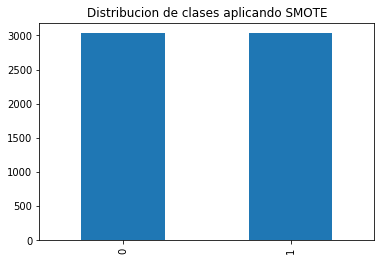

In [230]:
pd.Series(y_smote).value_counts().plot(kind='bar', title='Distribucion de clases aplicando SMOTE')

Este gráfico muestra claramente que ahora tenemos una gran cantidad de incendios que antes no teníamos. Esos son todos los puntos de datos sintéticos que se ha creado con SMOTE.



In [231]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_smote = X_smote.reshape(X_smote.shape[0],X_smote.shape[1],1)
X_smote.shape, y_smote.shape

((6058, 28, 1), (6058,))

In [232]:
X_smote_float=X_smote.astype(np.float32)

In [233]:
y_smote_int = y_smote.astype(np.int32)

In [234]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=5)

model_smote = modelLSTM(200, 'sigmoid', 0.2,'adam')

model_smote.fit(X_smote_float, y_smote_int,validation_data=(X_test, y_test),epochs=20,callbacks=[cp, earlyStop])

Epoch 1/20
186/190 [============================>.] - ETA: 0s - loss: 0.6720 - accuracy: 0.5800

190/190 [==============================] - 8s 32ms/step - loss: 0.6723 - accuracy: 0.5801 - val_loss: 0.5518 - val_accuracy: 0.8589
Epoch 2/20
190/190 [==============================] - 1s 5ms/step - loss: 0.6503 - accuracy: 0.6284 - val_loss: 0.6605 - val_accuracy: 0.6469
Epoch 3/20
190/190 [==============================] - 1s 5ms/step - loss: 0.6437 - accuracy: 0.6378 - val_loss: 0.6257 - val_accuracy: 0.6328
Epoch 4/20
190/190 [==============================] - 1s 5ms/step - loss: 0.6311 - accuracy: 0.6510 - val_loss: 0.7298 - val_accuracy: 0.5536
Epoch 5/20
190/190 [==============================] - 1s 5ms/step - loss: 0.6322 - accuracy: 0.6477 - val_loss: 0.6341 - val_accuracy: 0.6568
Epoch 6/20
190/190 [==============================] - 1s 5ms/step - loss: 0.6256 - accuracy: 0.6623 - val_loss: 0.7162 - val_accuracy: 0.6452
Epoch 6: early stopping


In [235]:
scores = model_smote.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_smote.metrics_names[1], scores[1] * 100))


38/38 - 0s - loss: 0.7162 - accuracy: 0.6452 - 100ms/epoch - 3ms/step
accuracy: 64.52%


In [236]:
# print classification report
y_pred_model_bal = model_smote.predict(X_test)

y_pred_model_bal_1 = np.argmax(y_pred_model_bal, axis=1)
print(classification_report(y_test, y_pred_model_bal_1))

38/38 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    1212.0

    accuracy                           0.00    1212.0
   macro avg       0.00      0.00      0.00    1212.0
weighted avg       0.00      0.00      0.00    1212.0



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

[[   0    0]
 [1212    0]]


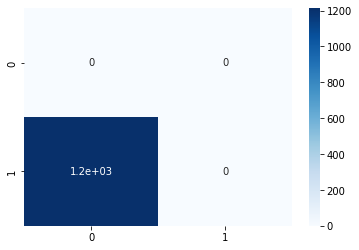

In [237]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model_bal_1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True,  cmap='Blues')

# 1.4.1 GridSearch - Modelo LSTM con division manual (X_smote_float, y_smote_int)

In [ ]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_smote_float, y_smote_int)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
final_model = grid_result.best_estimator_
final_model

In [ ]:
y_pred = final_model.predict(X_test.astype('float32'))

cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
y_pred = (final_model.predict_proba(X_test.astype('float32'))[:,1] >= 0.51).astype(bool)
cm = confusion_matrix(y_test, y_pred)
print(cm)
sns.heatmap(cm, cmap = 'Blues', annot=True)

# 1.5. Model LSTM clases balanceadas con RandomUnderSampler (y_train)


In [238]:
from imblearn.under_sampling import RandomUnderSampler

X_rus , y_rus = RandomUnderSampler().fit_resample(df_train_scaled, y_train)


print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_rus.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_rus.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_rus == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_rus == 0)))

Before OverSampling, counts of label '1': 1817
Before OverSampling, counts of label '0': 3029 

After OverSampling, the shape of train_X: (3634, 28)
After OverSampling, the shape of train_y: (3634,) 

After OverSampling, counts of label '1': 1817
After OverSampling, counts of label '0': 1817


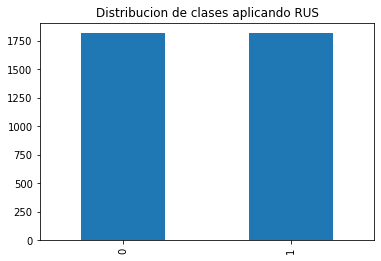

In [239]:
pd.Series(y_rus).value_counts().plot(kind='bar', title='Distribucion de clases aplicando RUS')

In [240]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_rus = X_rus.reshape(X_rus.shape[0],X_rus.shape[1],1)
X_rus.shape, y_rus.shape

((3634, 28, 1), (3634,))

In [241]:
X_rus_float=X_rus.astype(np.float32)

In [242]:
y_rus_int = y_rus.astype(np.int32)

In [243]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=10)

model_rus = modelLSTM(200, 'sigmoid', 0.2, 'adam')

model_rus.fit(X_rus_float, y_rus_int, validation_data=(X_test, y_test),epochs=20,callbacks=[cp, earlyStop])


Epoch 1/20
105/114 [==========================>...] - ETA: 0s - loss: 0.6833 - accuracy: 0.5554

114/114 [==============================] - 6s 43ms/step - loss: 0.6834 - accuracy: 0.5567 - val_loss: 0.6860 - val_accuracy: 0.7533
Epoch 2/20
106/114 [==========================>...] - ETA: 0s - loss: 0.6614 - accuracy: 0.6103

114/114 [==============================] - 4s 39ms/step - loss: 0.6587 - accuracy: 0.6150 - val_loss: 0.5143 - val_accuracy: 0.8366
Epoch 3/20
114/114 [==============================] - 1s 6ms/step - loss: 0.6575 - accuracy: 0.6205 - val_loss: 0.5502 - val_accuracy: 0.7979
Epoch 4/20
114/114 [==============================] - 1s 6ms/step - loss: 0.6439 - accuracy: 0.6354 - val_loss: 0.7282 - val_accuracy: 0.5363
Epoch 5/20
114/114 [==============================] - 1s 6ms/step - loss: 0.6404 - accuracy: 0.6335 - val_loss: 0.5628 - val_accuracy: 0.7368
Epoch 6/20
114/114 [==============================] - 1s 6ms/step - loss: 0.6363 - accuracy: 0.6417 - val_loss: 0.7439 - val_accuracy: 0.5371
Epoch 7/20
114/114 [==============================] - 1s 6ms/step - loss: 0.6313 - accuracy: 0.6489 - val_loss: 0.6871 - val_accuracy: 0.6584
Epoch 8/20
114/114 [==============================] - 1s 6ms/step - loss: 0.6333 - accuracy: 0.6453 - val_loss: 0.6649 - val_accuracy: 0.6856
Epoch 9/20
114/1

In [244]:
scores = model_rus.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_rus.metrics_names[1], scores[1] * 100))


38/38 - 0s - loss: 0.6832 - accuracy: 0.6559 - 101ms/epoch - 3ms/step
accuracy: 65.59%


In [245]:
# print classification report
y_pred_model_rus = model_rus.predict(X_test)

y_pred_model_rus_1 = np.argmax(y_pred_model_rus, axis=1)
print(classification_report(y_test, y_pred_model_rus_1))

38/38 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    1212.0

    accuracy                           0.00    1212.0
   macro avg       0.00      0.00      0.00    1212.0
weighted avg       0.00      0.00      0.00    1212.0



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

[[   0    0]
 [1212    0]]


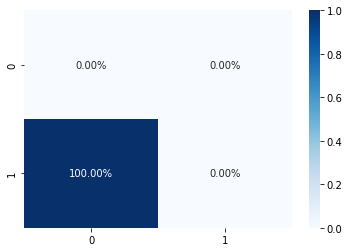

In [246]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model_rus_1)
print(cf_matrix)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# 1.5.1 GridSearch - Modelo LSTM con division manual (X_rus_float, y_rus_int)




In [ ]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_rus_float, y_rus_int)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
final_model = grid_result.best_estimator_
final_model

In [ ]:
y_pred = final_model.predict(X_test.astype('float32'))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [ ]:
y_pred = (final_model.predict_proba(X_test.astype('float32'))[:,1] >= 0.51).astype(bool)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

# 1.6. Model LSTM con pesos definidos por class_weight

In [247]:
#Definimos los pesos para el balanceo de clases.
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 0.7999339716077913, 1: 1.333516785910842}


In [248]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=8)

model_1 = modelLSTM(150, 'sigmoid', 0.3, 'adam')

model_1.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20,class_weight=class_weights, callbacks=[cp, earlyStop])

Epoch 1/20
144/152 [===========================>..] - ETA: 0s - loss: 0.6799 - accuracy: 0.5684

152/152 [==============================] - 7s 39ms/step - loss: 0.6789 - accuracy: 0.5697 - val_loss: 0.7631 - val_accuracy: 0.5520
Epoch 2/20
142/152 [===========================>..] - ETA: 0s - loss: 0.6520 - accuracy: 0.6089

152/152 [==============================] - 5s 31ms/step - loss: 0.6536 - accuracy: 0.6081 - val_loss: 0.6873 - val_accuracy: 0.6947
Epoch 3/20
152/152 [==============================] - ETA: 0s - loss: 0.6538 - accuracy: 0.5920

152/152 [==============================] - 5s 30ms/step - loss: 0.6538 - accuracy: 0.5920 - val_loss: 0.6009 - val_accuracy: 0.8729
Epoch 4/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6502 - accuracy: 0.6079 - val_loss: 0.6278 - val_accuracy: 0.6881
Epoch 5/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6503 - accuracy: 0.6304 - val_loss: 0.6928 - val_accuracy: 0.5957
Epoch 6/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6511 - accuracy: 0.6197 - val_loss: 0.7252 - val_accuracy: 0.6510
Epoch 7/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6427 - accuracy: 0.6195 - val_loss: 0.6055 - val_accuracy: 0.7360
Epoch 8/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6457 - accuracy: 0.6189 - val_loss: 0.6378 - val_accuracy: 0.7228
Epoch 9/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6359 - accuracy: 0.6288 - val_loss: 0.6093 - val_accuracy: 0.7459
Epoch 10/20
152/

In [249]:
scores = model_1.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

38/38 [==============================] - 0s 3ms/step - loss: 0.6027 - accuracy: 0.7715
Accuracy: 77.15%


In [250]:
y_pred_model_2 = model_1.predict(X_test.astype('float32'))

38/38 [==============================] - 0s 2ms/step


In [251]:
# print classification report
y_pred_model2 = np.argmax(y_pred_model_2, axis=1)
print(classification_report(y_test, y_pred_model2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    1212.0

    accuracy                           0.00    1212.0
   macro avg       0.00      0.00      0.00    1212.0
weighted avg       0.00      0.00      0.00    1212.0



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

[[   0    0]
 [1212    0]]


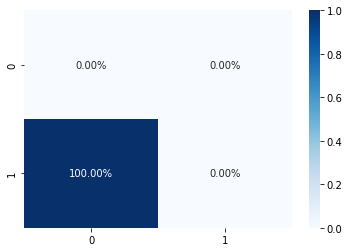

In [252]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model2)
print(cf_matrix)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# 2. Division de datos (Aleatoria)

---



In [46]:
from sklearn.model_selection import train_test_split

df_sin_movilidad = pd.read_csv("/content/drive/MyDrive/TFM/datos/df_sin_movilidad.csv", sep = ";")
df_sin_movilidad.index = df_sin_movilidad.fecha  ##Set_index('fecha')
df_sin_movilidad = df_sin_movilidad.drop('fecha', axis=1)

In [47]:
df_sin_movilidad = df_sin_movilidad.loc['2015-01-01':'2022-12-31']
print(df_sin_movilidad.shape)

(488345, 23)


In [48]:
df_sin_movilidad.groupby("ocurrencia").count()

,indicativo,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,...,porcentaje_pendiente_total,alto_riesgo,peligro,vulner,municipio,cod_municipio,laborable,dayofyear,weekend,mes
ocurrencia,,,,,,,,,,,,,,,,,,,,,
0,485316,485316,485316,485316,485316,485316,485316,485316,485316,485316,...,485316,485316,485316,485316,485316,485316,485316,485316,485316,485316
1,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029,...,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029


In [49]:
df_ocurrencia_0 = df_sin_movilidad[df_sin_movilidad["ocurrencia"]==0].sample(3029)

In [50]:
df_ocurrencia_1 = df_sin_movilidad[df_sin_movilidad["ocurrencia"]==1]

In [51]:
df_sin_movilidad =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])
df_sin_movilidad.shape

(6058, 23)

In [52]:
X = df_sin_movilidad.drop( ['ocurrencia', 'municipio', 'cod_municipio', 'indicativo'], axis=1)
y = df_sin_movilidad['ocurrencia']

In [53]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train_1

,prec,tmax,tmed,tmin,velmedia,racha,sol,presMax,presMin,rhum,altitud,porcentaje_pendiente_total,alto_riesgo,peligro,vulner,laborable,dayofyear,weekend,mes
fecha,,,,,,,,,,,,,,,,,,,
2016-07-08,0.0,14.9,14.1,13.4,1.2,4.8,500.0,980.0,979.8,65.0,1206.0,5.0,Sí,Moderat,Mitja,4,190,0,7
2019-06-13,0.0,27.0,26.3,25.4,0.8,3.3,987.0,1015.1,1014.6,28.0,508.0,4.1,No,Exclos,Moderada,3,164,0,6
2018-06-21,0.0,31.8,31.5,31.2,4.6,8.0,989.0,1008.3,1008.1,38.0,122.0,3.5,Sí,Alt,Molt Alta,3,172,0,6
2021-10-02,0.0,25.1,24.3,23.8,3.1,6.2,574.0,1016.7,1016.1,72.0,852.0,4.1,Sí,Molt Alt,Moderada,5,275,1,10
2019-12-15,0.0,14.8,14.6,14.3,3.9,7.1,438.0,972.4,972.2,55.0,463.0,0.5,Sí,Molt Alt,Moderada,6,349,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-17,0.0,19.4,18.9,18.4,3.3,6.3,663.0,1005.7,1005.4,52.0,430.0,3.1,Sí,Molt Alt,Molt Alta,1,138,0,5
2016-01-31,0.0,9.3,8.7,8.3,0.6,1.8,239.0,948.7,948.3,75.0,956.0,1.6,Sí,Alt,Mitja,6,31,1,1
2017-11-08,0.0,13.3,13.2,13.1,5.4,8.4,303.0,976.8,975.8,49.0,304.0,9.0,Sí,Exclos,Baixa,2,312,0,11


#2.1 Normalizacion datos



In [54]:
# normalizacion de los datos numericos
from sklearn.preprocessing import StandardScaler
numericalCols_train_1 = X_train_1[["prec","tmed","tmax", "tmin", "velmedia", "racha", "sol", "presMax","presMin","rhum", "altitud", "porcentaje_pendiente_total"]] 
numericalCols_test_1 = X_test_1[["prec","tmed","tmax", "tmin","velmedia", "racha", "sol", "presMax","presMin","rhum", "altitud", "porcentaje_pendiente_total"]] 

scaler = StandardScaler()
scaler.fit(numericalCols_train_1)

numericalCols_train_scaled_1 = scaler.transform(numericalCols_train_1)
numericalCols_test_scaled_1 = scaler.transform(numericalCols_test_1)

numericalCols_train_scaled_1.shape , numericalCols_test_scaled_1.shape

((4846, 12), (1212, 12))

In [55]:
# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_train_1 = X_train_1[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	vulner
categoricalCols_train_1 = OneHotEncoder().fit_transform(categoricalCols_train_1).toarray()

# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_test_1 = X_test_1[['alto_riesgo',	'peligro',	'vulner']]  #alto_riesgo	peligro	 y vulner
categoricalCols_test_1 = OneHotEncoder().fit_transform(categoricalCols_test_1).toarray()

categoricalCols_train_1.shape, categoricalCols_test_1.shape

((4846, 12), (1212, 12))

In [56]:
Other_var_train_1 = X_train_1[['laborable', 	'dayofyear', 	'weekend', 	'mes']]
Other_var_test_1 = X_test_1[['laborable', 	'dayofyear', 	'weekend', 	'mes']]  #alto_riesgo	peligro	 y vulner

In [57]:
df_train_scaled_1 = np.concatenate((numericalCols_train_scaled_1 , categoricalCols_train_1, Other_var_train_1), axis=1)
df_test_scaled_1 = np.concatenate((numericalCols_test_scaled_1 , categoricalCols_test_1, Other_var_test_1), axis=1)

In [58]:
df_train_scaled_1.shape, y_train_1.shape, df_test_scaled_1.shape, y_test_1.shape

((4846, 28), (4846,), (1212, 28), (1212,))

In [59]:
X_train_1 = df_train_scaled_1.reshape(df_train_scaled_1.shape[0],df_train_scaled_1.shape[1],1)
X_train_1.shape, y_train_1.shape

((4846, 28, 1), (4846,))

In [60]:
X_test_1 = df_test_scaled_1.reshape(df_test_scaled_1.shape[0],df_test_scaled_1.shape[1],1)
X_test_1.shape, y_test_1.shape

((1212, 28, 1), (1212,))

# 2.2 Model LSTM (df_sin_mov - Division Aleatoria)

In [268]:
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import InputLayer


def modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 32):
    model=Sequential()
    model.add(InputLayer((28,1)))
    model.add(LSTM(n_lstm))
    model.add(Dropout(dropout_rate))
    model.add(Dense(28, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [269]:
model_shuffle = modelLSTM()

In [270]:
model_shuffle.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 200)               161600    
                                                                 
 dropout_38 (Dropout)        (None, 200)               0         
                                                                 
 dense_38 (Dense)            (None, 28)                5628      
                                                                 
 dropout_39 (Dropout)        (None, 28)                0         
                                                                 
 dense_39 (Dense)            (None, 1)                 29        
                                                                 
Total params: 167,257
Trainable params: 167,257
Non-trainable params: 0
_________________________________________________________________


In [271]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=3, patience=10)

model_shuffle.fit(X_train_1, y_train_1,validation_data=(X_test_1, y_test_1),epochs=20, callbacks=[cp, earlyStop])

Epoch 1/20
149/152 [============================>.] - ETA: 0s - loss: 0.6782 - accuracy: 0.5812

152/152 [==============================] - 7s 34ms/step - loss: 0.6775 - accuracy: 0.5823 - val_loss: 0.6745 - val_accuracy: 0.6163
Epoch 2/20
145/152 [===========================>..] - ETA: 0s - loss: 0.6499 - accuracy: 0.6239

152/152 [==============================] - 6s 38ms/step - loss: 0.6507 - accuracy: 0.6230 - val_loss: 0.6715 - val_accuracy: 0.5767
Epoch 3/20
145/152 [===========================>..] - ETA: 0s - loss: 0.6493 - accuracy: 0.6300

152/152 [==============================] - 5s 32ms/step - loss: 0.6474 - accuracy: 0.6327 - val_loss: 0.6624 - val_accuracy: 0.6229
Epoch 4/20
144/152 [===========================>..] - ETA: 0s - loss: 0.6415 - accuracy: 0.6298

152/152 [==============================] - 5s 31ms/step - loss: 0.6405 - accuracy: 0.6314 - val_loss: 0.6539 - val_accuracy: 0.6221
Epoch 5/20
143/152 [===========================>..] - ETA: 0s - loss: 0.6372 - accuracy: 0.6385

152/152 [==============================] - 5s 31ms/step - loss: 0.6367 - accuracy: 0.6385 - val_loss: 0.6472 - val_accuracy: 0.6089
Epoch 6/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6375 - accuracy: 0.6356 - val_loss: 0.6518 - val_accuracy: 0.6345
Epoch 7/20
152/152 [==============================] - 1s 7ms/step - loss: 0.6343 - accuracy: 0.6397 - val_loss: 0.6480 - val_accuracy: 0.6287
Epoch 8/20
149/152 [============================>.] - ETA: 0s - loss: 0.6297 - accuracy: 0.6489

152/152 [==============================] - 6s 41ms/step - loss: 0.6309 - accuracy: 0.6471 - val_loss: 0.6407 - val_accuracy: 0.6485
Epoch 9/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6350 - accuracy: 0.6447 - val_loss: 0.6461 - val_accuracy: 0.6485
Epoch 10/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6311 - accuracy: 0.6457 - val_loss: 0.6525 - val_accuracy: 0.6221
Epoch 11/20
152/152 [==============================] - 1s 9ms/step - loss: 0.6332 - accuracy: 0.6461 - val_loss: 0.6558 - val_accuracy: 0.6106
Epoch 12/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6326 - accuracy: 0.6463 - val_loss: 0.6446 - val_accuracy: 0.6411
Epoch 13/20
149/152 [============================>.] - ETA: 0s - loss: 0.6282 - accuracy: 0.6535

152/152 [==============================] - 6s 37ms/step - loss: 0.6290 - accuracy: 0.6523 - val_loss: 0.6392 - val_accuracy: 0.6411
Epoch 14/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6272 - accuracy: 0.6480 - val_loss: 0.6458 - val_accuracy: 0.6328
Epoch 15/20
152/152 [==============================] - 1s 7ms/step - loss: 0.6282 - accuracy: 0.6502 - val_loss: 0.6453 - val_accuracy: 0.6312
Epoch 16/20
152/152 [==============================] - 1s 7ms/step - loss: 0.6262 - accuracy: 0.6517 - val_loss: 0.6405 - val_accuracy: 0.6535
Epoch 17/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6250 - accuracy: 0.6587 - val_loss: 0.6472 - val_accuracy: 0.6452
Epoch 18/20
152/152 [==============================] - 1s 6ms/step - loss: 0.6254 - accuracy: 0.6577 - val_loss: 0.6400 - val_accuracy: 0.6427
Epoch 19/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6213 - accuracy: 0.6603 - val_loss: 0.6427 - val_accuracy: 0.6477
Epoch 20/2

152/152 [==============================] - 5s 33ms/step - loss: 0.6245 - accuracy: 0.6550 - val_loss: 0.6388 - val_accuracy: 0.6469


In [272]:
scores = model_shuffle.evaluate(X_test_1, y_test_1, verbose=2)
print("%s: %.2f%%" % (model_shuffle.metrics_names[1], scores[1] * 100))

38/38 - 0s - loss: 0.6388 - accuracy: 0.6469 - 119ms/epoch - 3ms/step
accuracy: 64.69%


In [273]:
y_pred_model_1 = model_shuffle.predict(X_test_1)

38/38 [==============================] - 0s 2ms/step


In [274]:
# print classification report
y_pred_model1 = np.argmax(y_pred_model_1, axis=1)
print(classification_report(y_test_1, y_pred_model1))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68       626
           1       0.00      0.00      0.00       586

    accuracy                           0.52      1212
   macro avg       0.26      0.50      0.34      1212
weighted avg       0.27      0.52      0.35      1212



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[626   0]
 [586   0]]


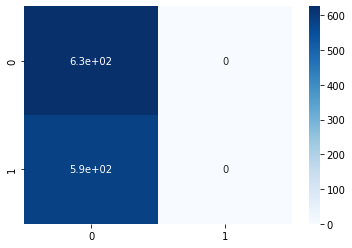

In [275]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test_1, y_pred_model1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

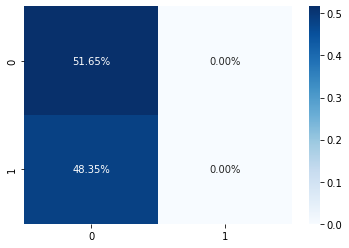

In [276]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

# 2.2.1 GridSearch -  Hiperparametros del modelo LSTM con division aleatoria  (X_train_1, y_train_1)

In [61]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_train_1, y_train_1)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.641558 using {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.635574 (0.017219) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.510321 (0.013721) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.630827 (0.015660) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.506398 (0.011619) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.641558 (0.007911) with: {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.513616 (0.020967) with: {'batch_size': 64, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}


In [62]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7f31ec8d0430>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

[[155 437]
 [165 455]]


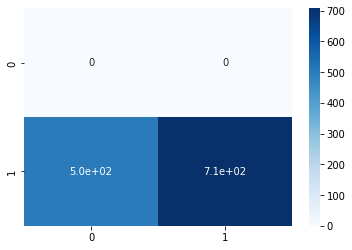

In [72]:
y_pred = final_model.predict(X_test_1.astype('float32'))
print(cm)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [73]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.58      0.62       592
           1       0.65      0.74      0.69       620

    accuracy                           0.66      1212
   macro avg       0.66      0.66      0.66      1212
weighted avg       0.66      0.66      0.66      1212



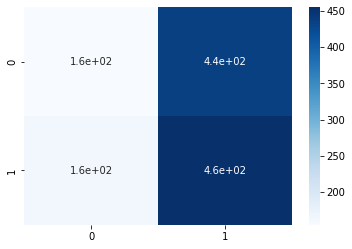

In [70]:
y_pred = (final_model.predict_proba(X_test.astype('float32'))[:,1] >= 0.51).astype(bool)
cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [71]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.26      0.34       592
           1       0.51      0.73      0.60       620

    accuracy                           0.50      1212
   macro avg       0.50      0.50      0.47      1212
weighted avg       0.50      0.50      0.47      1212



# 2.3. Model LSTM division aleatoria con SMOTE

In [74]:
from imblearn.over_sampling import SMOTE 
X_smote_1 , y_smote_1 = SMOTE().fit_resample( df_train_scaled_1, y_train_1)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train_1 == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train_1 == 0)))

print('After OverSampling, the shape of train_X: {}'.format(X_smote_1.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_smote_1.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_smote_1 == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_smote_1 == 0)))

Before OverSampling, counts of label '1': 2409
Before OverSampling, counts of label '0': 2437 

After OverSampling, the shape of train_X: (4874, 28)
After OverSampling, the shape of train_y: (4874,) 

After OverSampling, counts of label '1': 2437
After OverSampling, counts of label '0': 2437


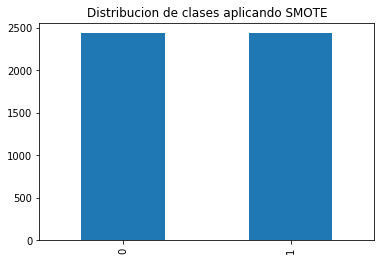

In [75]:
pd.Series(y_smote_1).value_counts().plot(kind='bar', title='Distribucion de clases aplicando SMOTE')

Este gráfico muestra claramente que ahora tenemos una gran cantidad de incendios que antes no teníamos. Esos son todos los puntos de datos sintéticos que se ha creado con SMOTE.



In [76]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_smote_1 = X_smote_1.reshape(X_smote_1.shape[0],X_smote_1.shape[1],1)
X_smote_1.shape, y_smote_1.shape

((4874, 28, 1), (4874,))

In [77]:
X_smote_float_1 =X_smote_1.astype(np.float32)

In [78]:
y_smote_int_1 = y_smote_1.astype(np.int32)

In [79]:
X_test_1.shape, y_test_1.shape, X_smote_float_1.shape, y_smote_int_1.shape

((1212, 28, 1), (1212,), (4874, 28, 1), (4874,))

In [80]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=10)

model_smote = modelLSTM(200, 'sigmoid', 0.2,'adam')

model_smote.fit(X_smote_float_1, y_smote_int_1,validation_data=(X_test_1, y_test_1),epochs=20,callbacks=[cp, earlyStop])

Epoch 1/20
149/153 [============================>.] - ETA: 0s - loss: 0.6742 - accuracy: 0.5879

153/153 [==============================] - 7s 33ms/step - loss: 0.6742 - accuracy: 0.5876 - val_loss: 0.6569 - val_accuracy: 0.6394
Epoch 2/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6578 - accuracy: 0.6202 - val_loss: 0.6656 - val_accuracy: 0.6155
Epoch 3/20
151/153 [============================>.] - ETA: 0s - loss: 0.6539 - accuracy: 0.6229

153/153 [==============================] - 5s 30ms/step - loss: 0.6542 - accuracy: 0.6219 - val_loss: 0.6523 - val_accuracy: 0.6097
Epoch 4/20
151/153 [============================>.] - ETA: 0s - loss: 0.6468 - accuracy: 0.6213

153/153 [==============================] - 5s 32ms/step - loss: 0.6466 - accuracy: 0.6221 - val_loss: 0.6410 - val_accuracy: 0.6378
Epoch 5/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6430 - accuracy: 0.6317 - val_loss: 0.6473 - val_accuracy: 0.6436
Epoch 6/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6463 - accuracy: 0.6274 - val_loss: 0.6560 - val_accuracy: 0.6394
Epoch 7/20
149/153 [============================>.] - ETA: 0s - loss: 0.6442 - accuracy: 0.6334

153/153 [==============================] - 5s 30ms/step - loss: 0.6454 - accuracy: 0.6332 - val_loss: 0.6407 - val_accuracy: 0.6378
Epoch 8/20
153/153 [==============================] - 1s 7ms/step - loss: 0.6447 - accuracy: 0.6280 - val_loss: 0.6473 - val_accuracy: 0.6254
Epoch 9/20
149/153 [============================>.] - ETA: 0s - loss: 0.6416 - accuracy: 0.6378

153/153 [==============================] - 5s 36ms/step - loss: 0.6412 - accuracy: 0.6389 - val_loss: 0.6403 - val_accuracy: 0.6295
Epoch 10/20
148/153 [============================>.] - ETA: 0s - loss: 0.6452 - accuracy: 0.6296

153/153 [==============================] - 5s 35ms/step - loss: 0.6446 - accuracy: 0.6311 - val_loss: 0.6328 - val_accuracy: 0.6584
Epoch 11/20
151/153 [============================>.] - ETA: 0s - loss: 0.6459 - accuracy: 0.6285

153/153 [==============================] - 5s 32ms/step - loss: 0.6451 - accuracy: 0.6295 - val_loss: 0.6319 - val_accuracy: 0.6502
Epoch 12/20
152/153 [============================>.] - ETA: 0s - loss: 0.6381 - accuracy: 0.6454

153/153 [==============================] - 5s 31ms/step - loss: 0.6378 - accuracy: 0.6459 - val_loss: 0.6317 - val_accuracy: 0.6469
Epoch 13/20
151/153 [============================>.] - ETA: 0s - loss: 0.6363 - accuracy: 0.6397

153/153 [==============================] - 4s 29ms/step - loss: 0.6361 - accuracy: 0.6399 - val_loss: 0.6236 - val_accuracy: 0.6658
Epoch 14/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6397 - accuracy: 0.6364 - val_loss: 0.6405 - val_accuracy: 0.6254
Epoch 15/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6358 - accuracy: 0.6422 - val_loss: 0.6237 - val_accuracy: 0.6551
Epoch 16/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6365 - accuracy: 0.6446 - val_loss: 0.6280 - val_accuracy: 0.6485
Epoch 17/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6335 - accuracy: 0.6418 - val_loss: 0.6329 - val_accuracy: 0.6617
Epoch 18/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6321 - accuracy: 0.6461 - val_loss: 0.6294 - val_accuracy: 0.6469
Epoch 19/20
153/153 [==============================] - 1s 5ms/step - loss: 0.6354 - accuracy: 0.6453 - val_loss: 0.6246 - val_accuracy: 0.6576
Epoch 20/2

In [81]:
scores = model_smote.evaluate(X_test_1, y_test_1, verbose=2)
print("%s: %.2f%%" % (model_smote.metrics_names[1], scores[1] * 100))


38/38 - 0s - loss: 0.6264 - accuracy: 0.6568 - 100ms/epoch - 3ms/step
accuracy: 65.68%


In [82]:
# print classification report
y_pred_model_bal = model_smote.predict(X_test_1)

y_pred_model_bal_1 = np.argmax(y_pred_model_bal, axis=1)
print(classification_report(y_test_1, y_pred_model_bal_1))

38/38 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       592
           1       0.00      0.00      0.00       620

    accuracy                           0.49      1212
   macro avg       0.24      0.50      0.33      1212
weighted avg       0.24      0.49      0.32      1212



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[592   0]
 [620   0]]


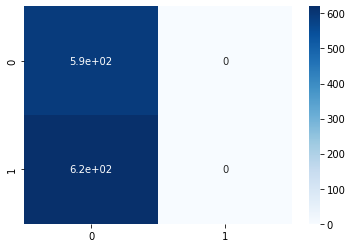

In [83]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test_1, y_pred_model_bal_1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True,  cmap='Blues')

# 2.3.1 GridSearch - Modelo LSTM con division aleatoria Smote (X_smote_float, y_smote_int)

In [84]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_smote_float_1, y_smote_int_1)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.649365 using {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.631312 (0.020861) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.000459) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.000459) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.637879 (0.020991) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.539390 (0.030476) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.000459) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [85]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7f31ec8d0430>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

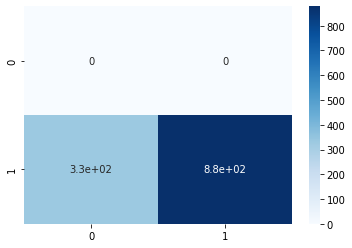

In [86]:
y_pred = final_model.predict(X_test.astype('float32'))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [87]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.27      0.34       592
           1       0.51      0.72      0.59       620

    accuracy                           0.50      1212
   macro avg       0.49      0.49      0.47      1212
weighted avg       0.49      0.50      0.47      1212



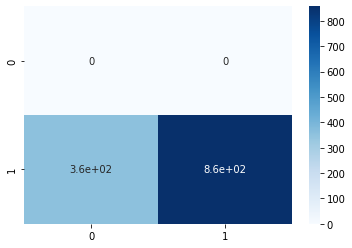

In [88]:
y_pred = (final_model.predict_proba(X_test.astype('float32'))[:,1] >= 0.51).astype(bool)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [89]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.29      0.36       592
           1       0.51      0.70      0.59       620

    accuracy                           0.50      1212
   macro avg       0.50      0.50      0.48      1212
weighted avg       0.50      0.50      0.48      1212



# 2.4 Model LSTM - Division Aleatoria - Balanceo de clases RandomUnderSampler (y_train_1)


In [90]:
from imblearn.under_sampling import RandomUnderSampler

X_rus , y_rus = RandomUnderSampler().fit_resample(df_train_scaled_1, y_train_1)

print("Before UnderSampling, counts of label '1': {}".format(sum(y_train_1 == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train_1 == 0)))

print('After UnderSampling, the shape of train_X: {}'.format(X_rus.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_rus.shape))
  
print("After UnderSampling, counts of label '1': {}".format(sum(y_rus == 1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_rus == 0)))

Before UnderSampling, counts of label '1': 2409
Before UnderSampling, counts of label '0': 2437 

After UnderSampling, the shape of train_X: (4818, 28)
After UnderSampling, the shape of train_y: (4818,) 

After UnderSampling, counts of label '1': 2409
After UnderSampling, counts of label '0': 2409


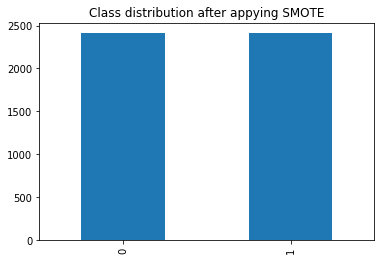

In [91]:
pd.Series(y_rus).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE')

In [92]:
#Escalamos los datos de smote para que tengan la dimension correcta para el modelo
X_rus = X_rus.reshape(X_rus.shape[0],X_rus.shape[1],1)
X_rus.shape, y_rus.shape

((4818, 28, 1), (4818,))

In [93]:
X_rus_float = X_rus.astype(np.float32)

In [94]:
y_rus_int = y_rus.astype(np.int32)

In [95]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2, patience=20)

model_shuffle_rus = modelLSTM(200, 'sigmoid', 0.2,'adam')

model_shuffle_rus.fit(X_rus_float, y_rus_int,validation_data=(X_test_1, y_test_1),epochs=20,callbacks=[cp, earlyStop])

Epoch 1/20
143/151 [===========================>..] - ETA: 0s - loss: 0.6841 - accuracy: 0.5822

151/151 [==============================] - 6s 32ms/step - loss: 0.6833 - accuracy: 0.5832 - val_loss: 0.6476 - val_accuracy: 0.6353
Epoch 2/20
151/151 [==============================] - 1s 5ms/step - loss: 0.6565 - accuracy: 0.6241 - val_loss: 0.6556 - val_accuracy: 0.6262
Epoch 3/20
143/151 [===========================>..] - ETA: 0s - loss: 0.6497 - accuracy: 0.6320

151/151 [==============================] - 5s 31ms/step - loss: 0.6508 - accuracy: 0.6310 - val_loss: 0.6349 - val_accuracy: 0.6510
Epoch 4/20
151/151 [==============================] - 1s 5ms/step - loss: 0.6435 - accuracy: 0.6335 - val_loss: 0.6428 - val_accuracy: 0.6312
Epoch 5/20
151/151 [==============================] - 1s 5ms/step - loss: 0.6427 - accuracy: 0.6366 - val_loss: 0.6401 - val_accuracy: 0.6584
Epoch 6/20
151/151 [==============================] - 1s 5ms/step - loss: 0.6425 - accuracy: 0.6399 - val_loss: 0.6457 - val_accuracy: 0.6196
Epoch 7/20
151/151 [==============================] - 1s 5ms/step - loss: 0.6385 - accuracy: 0.6440 - val_loss: 0.6353 - val_accuracy: 0.6452
Epoch 8/20
141/151 [===========================>..] - ETA: 0s - loss: 0.6396 - accuracy: 0.6489

151/151 [==============================] - 4s 30ms/step - loss: 0.6399 - accuracy: 0.6465 - val_loss: 0.6336 - val_accuracy: 0.6444
Epoch 9/20
151/151 [==============================] - 1s 6ms/step - loss: 0.6373 - accuracy: 0.6391 - val_loss: 0.6441 - val_accuracy: 0.6337
Epoch 10/20
151/151 [==============================] - 1s 5ms/step - loss: 0.6356 - accuracy: 0.6405 - val_loss: 0.6358 - val_accuracy: 0.6469
Epoch 11/20
141/151 [===========================>..] - ETA: 0s - loss: 0.6374 - accuracy: 0.6390

151/151 [==============================] - 5s 32ms/step - loss: 0.6364 - accuracy: 0.6407 - val_loss: 0.6255 - val_accuracy: 0.6650
Epoch 12/20
151/151 [==============================] - 1s 5ms/step - loss: 0.6393 - accuracy: 0.6405 - val_loss: 0.6306 - val_accuracy: 0.6535
Epoch 13/20
151/151 [==============================] - 1s 5ms/step - loss: 0.6360 - accuracy: 0.6428 - val_loss: 0.6287 - val_accuracy: 0.6617
Epoch 14/20
151/151 [==============================] - 1s 5ms/step - loss: 0.6304 - accuracy: 0.6434 - val_loss: 0.6299 - val_accuracy: 0.6403
Epoch 15/20
146/151 [============================>.] - ETA: 0s - loss: 0.6328 - accuracy: 0.6468

151/151 [==============================] - 4s 29ms/step - loss: 0.6324 - accuracy: 0.6478 - val_loss: 0.6232 - val_accuracy: 0.6617
Epoch 16/20
151/151 [==============================] - 1s 5ms/step - loss: 0.6338 - accuracy: 0.6386 - val_loss: 0.6246 - val_accuracy: 0.6667
Epoch 17/20
151/151 [==============================] - 1s 5ms/step - loss: 0.6366 - accuracy: 0.6418 - val_loss: 0.6341 - val_accuracy: 0.6510
Epoch 18/20
146/151 [============================>.] - ETA: 0s - loss: 0.6349 - accuracy: 0.6458

151/151 [==============================] - 5s 32ms/step - loss: 0.6339 - accuracy: 0.6476 - val_loss: 0.6220 - val_accuracy: 0.6551
Epoch 19/20
151/151 [==============================] - 1s 6ms/step - loss: 0.6325 - accuracy: 0.6467 - val_loss: 0.6223 - val_accuracy: 0.6576
Epoch 20/20
151/151 [==============================] - 1s 5ms/step - loss: 0.6309 - accuracy: 0.6486 - val_loss: 0.6307 - val_accuracy: 0.6444


In [96]:
scores = model_shuffle_rus.evaluate(X_test_1, y_test_1, verbose=2)
print("%s: %.2f%%" % (model_shuffle_rus.metrics_names[1], scores[1] * 100))


38/38 - 0s - loss: 0.6307 - accuracy: 0.6444 - 99ms/epoch - 3ms/step
accuracy: 64.44%


In [97]:
# print classification report
y_pred_model_bal = model_shuffle_rus.predict(X_test_1)

y_pred_model_bal_1 = np.argmax(y_pred_model_bal, axis=1)
print(classification_report(y_test_1, y_pred_model_bal_1))

38/38 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       592
           1       0.00      0.00      0.00       620

    accuracy                           0.49      1212
   macro avg       0.24      0.50      0.33      1212
weighted avg       0.24      0.49      0.32      1212



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[592   0]
 [620   0]]


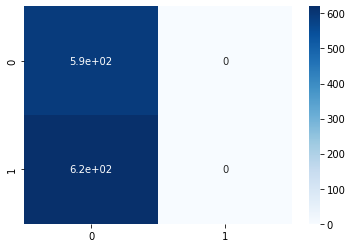

In [98]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test_1, y_pred_model_bal_1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True,  cmap='Blues')

# GridSearch - Modelo LSTM con division manual (X_rus, y_rus)

In [99]:
# create model
model = KerasClassifier(model=modelLSTM, verbose=3, loss="binary_crossentropy", epochs=20, batch_size=32)

# define the grid search parameters
batch_size = [16, 32, 64]
epochs = [20]
optimizer = ['adam']
class_weight = [{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}]


param_grid = dict(batch_size=batch_size,
                  epochs=epochs,
                  optimizer=optimizer,
                  class_weight= class_weight
                  )
#Grid
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    n_jobs=-1, 
                    cv=5)

grid_result = grid.fit(X_rus_float, y_rus_int)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Best: 0.639685 using {'batch_size': 64, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.636988 (0.016321) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.509344 (0.015052) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.000328) with: {'batch_size': 16, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.635744 (0.018574) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 1}, 'epochs': 20, 'optimizer': 'adam'}
0.510167 (0.017824) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 5}, 'epochs': 20, 'optimizer': 'adam'}
0.500000 (0.000328) with: {'batch_size': 32, 'class_weight': {0: 1, 1: 10}, 'epochs': 20, 'optimizer': 'adam'}
0.

In [100]:
final_model = grid_result.best_estimator_
final_model

KerasClassifier(
	model=<function modelLSTM at 0x7f31ec8d0430>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=binary_crossentropy
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=3
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=20
	class_weight={0: 1, 1: 1}
)

In [101]:
y_pred = final_model.predict(X_test_1.astype(np.float32))

In [102]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.62      0.63       592
           1       0.65      0.69      0.67       620

    accuracy                           0.65      1212
   macro avg       0.65      0.65      0.65      1212
weighted avg       0.65      0.65      0.65      1212



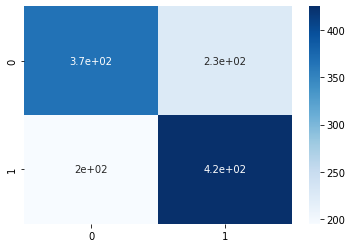

In [103]:
cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

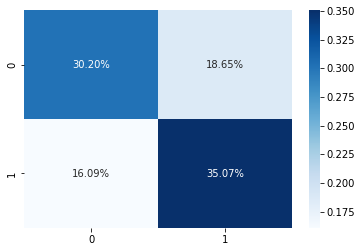

In [104]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

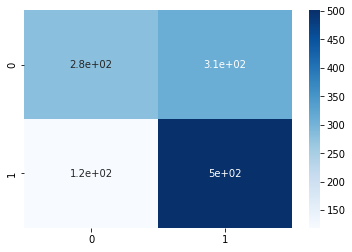

In [105]:
y_pred = (final_model.predict_proba(X_test_1.astype(np.float32))[:,1] >= 0.4).astype(bool)
cm = confusion_matrix(y_test_1, y_pred)
sns.heatmap(cm, cmap = 'Blues', annot=True)

In [106]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.47      0.57       592
           1       0.62      0.81      0.70       620

    accuracy                           0.65      1212
   macro avg       0.66      0.64      0.63      1212
weighted avg       0.66      0.65      0.63      1212



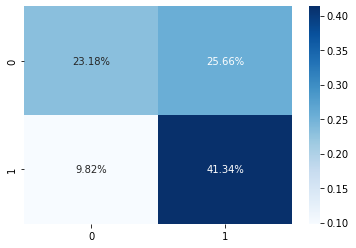

In [107]:
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

In [108]:
print(f'Conjunto de datos de validación')
print(f'  Exactitud:     { accuracy_score(y_test_1, y_pred) :0.5f}')
print(f'  Precisión:     { precision_score(y_test_1, y_pred, average = "macro") :0.5f}')
print(f'  Exhaustividad: { recall_score(y_test_1, y_pred, average = "macro") :0.5f}')


Conjunto de datos de validación
  Exactitud:     0.64521
  Precisión:     0.65975
  Exhaustividad: 0.64136


In [109]:
print(classification_report(y_test_1, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.47      0.57       592
           1       0.62      0.81      0.70       620

    accuracy                           0.65      1212
   macro avg       0.66      0.64      0.63      1212
weighted avg       0.66      0.65      0.63      1212



#Variables importantes (Modelo Simple)

---



#Seleccion de variables importantes (Modelo Simple)


In [296]:
df_sin_movilidad.columns

Index(['indicativo', 'prec', 'tmax', 'tmed', 'tmin', 'velmedia', 'racha',
       'sol', 'presMax', 'presMin', 'rhum', 'altitud',
       'porcentaje_pendiente_total', 'alto_riesgo', 'peligro', 'vulner',
       'ocurrencia', 'municipio', 'cod_municipio', 'laborable', 'dayofyear',
       'weekend', 'mes'],
      dtype='object')

In [297]:
df_sin_movilidad_importances = df_sin_movilidad.drop([ 'indicativo', 'tmed', 'tmin', 'presMin', 'municipio', 'cod_municipio', 'porcentaje_pendiente_total','altitud', 'vulner', 'alto_riesgo', 'laborable', 'weekend'], axis=1)
df_sin_movilidad_importances

,prec,tmax,velmedia,racha,sol,presMax,rhum,peligro,ocurrencia,dayofyear,mes
fecha,,,,,,,,,,,
2018-07-09,0.0,32.0,4.8,8.9,976.0,1002.5,41.0,Alt,0,190,7
2020-02-23,0.0,16.2,0.5,1.7,640.0,994.0,64.0,Exclos,0,54,2
2016-03-17,0.0,15.7,2.2,8.9,7.8,1012.0,97.0,Exclos,0,77,3
2015-01-31,0.0,12.8,3.9,9.7,565.0,987.4,44.0,Exclos,0,31,1
2018-05-02,0.0,21.9,2.3,6.9,942.0,931.6,27.0,Molt Alt,0,122,5
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-21,0.0,11.9,1.8,4.0,450.0,1020.4,90.0,Moderat,1,355,12
2021-12-23,0.0,14.0,14.0,17.8,459.0,1003.0,76.0,Molt Alt,1,357,12
2021-12-29,0.0,18.1,1.6,4.1,309.0,1009.8,63.0,Exclos,1,363,12


In [298]:
df_sin_movilidad_importances.groupby("ocurrencia").count()

,prec,tmax,velmedia,racha,sol,presMax,rhum,peligro,dayofyear,mes
ocurrencia,,,,,,,,,,
0,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029
1,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029


In [299]:
df_sin_movilidad_importances.groupby("ocurrencia").count().columns

Index(['prec', 'tmax', 'velmedia', 'racha', 'sol', 'presMax', 'rhum',
       'peligro', 'dayofyear', 'mes'],
      dtype='object')

In [300]:
df_ocurrencia_0 = df_sin_movilidad_importances[df_sin_movilidad_importances["ocurrencia"]==0].sample(3029)

In [301]:
df_ocurrencia_1 = df_sin_movilidad_importances[df_sin_movilidad_importances["ocurrencia"]==1]

In [336]:
df_sin_movilidad_importances =  pd.concat([df_ocurrencia_0, df_ocurrencia_1])

In [303]:
X = df_sin_movilidad_importances.drop( ['ocurrencia'], axis=1)
y = df_sin_movilidad_importances['ocurrencia']


In [304]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2)

In [337]:
df_sin_movilidad.shape,  X_train_2.shape, y_train_2.shape, X_test_2.shape, y_test_2.shape

((6058, 23), (4846, 10), (4846,), (1212, 10), (1212,))

##Normalizacion

In [338]:
# normalizacion de los datos numericos
numericalCols_train = X_train_2[['prec'	,'tmax',	'velmedia',	'racha',	'sol'	,'presMax',	'rhum']]
numericalCols_test = X_test_2[['prec'	,'tmax',	'velmedia',	'racha',	'sol'	,'presMax',	'rhum']]

scaler = StandardScaler()
scaler.fit(numericalCols_train)

numericalCols_train_scaled = scaler.transform(numericalCols_train)
numericalCols_test_scaled = scaler.transform(numericalCols_test)

numericalCols_train_scaled.shape , numericalCols_test_scaled.shape

((4846, 7), (1212, 7))

In [339]:
# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_train = X_train_2[[	'peligro']]  #alto_riesgo	peligro	vulner
categoricalCols_train = OneHotEncoder().fit_transform(categoricalCols_train).toarray()


# normalizacion de los datos categoricos , sin la ocurrencia
categoricalCols_test = X_test_2[['peligro']]   #alto_riesgo	peligro	 y vulner
categoricalCols_test = OneHotEncoder().fit_transform(categoricalCols_test).toarray()

categoricalCols_train.shape, categoricalCols_test.shape

((4846, 5), (1212, 5))

In [340]:
Other_var_train = X_train_2[[	'mes', 'dayofyear']]
Other_var_test = X_test_2[[	'mes', 'dayofyear']]  #alto_riesgo	peligro	 y vulner

In [358]:
df_train_scaled = np.concatenate((numericalCols_train_scaled , categoricalCols_train, Other_var_train), axis=1)
df_test_scaled = np.concatenate((numericalCols_test_scaled , categoricalCols_test, Other_var_test), axis=1)
df_train_scaled.shape

(4846, 14)

In [344]:
X_test = df_test_scaled
X_train = df_train_scaled

array([[-7.82713460e-02,  1.11319949e+00,  7.32077940e-01, ...,
         0.00000000e+00,  6.00000000e+00,  1.67000000e+02],
       [-7.82713460e-02,  5.37942048e-01,  4.34385561e-01, ...,
         0.00000000e+00,  6.00000000e+00,  1.73000000e+02],
       [-7.82713460e-02,  1.78237652e+00,  3.35154768e-01, ...,
         1.00000000e+00,  6.00000000e+00,  1.74000000e+02],
       ...,
       [-7.82713460e-02,  1.85743612e-01, -1.05407633e+00, ...,
         0.00000000e+00,  1.00000000e+01,  2.83000000e+02],
       [-7.82713460e-02, -1.42262925e+00,  4.84000958e-01, ...,
         0.00000000e+00,  1.00000000e+01,  2.75000000e+02],
       [-7.82713460e-02, -1.29348982e+00, -9.54845542e-01, ...,
         0.00000000e+00,  3.00000000e+00,  6.40000000e+01]])

##Model LSTM (Variables importantes)

In [316]:
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import InputLayer


def modelLSTM(n_lstm = 200, activation = 'sigmoid',dropout_rate =0.2, optimizer='adam', batch_size = 64):
    model=Sequential()
    model.add(InputLayer((14,1)))
    model.add(LSTM(n_lstm))
    model.add(Dropout(dropout_rate))
    model.add(Dense(14, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [317]:
model_import = modelLSTM()

In [318]:
model_import.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 200)               161600    
                                                                 
 dropout_46 (Dropout)        (None, 200)               0         
                                                                 
 dense_46 (Dense)            (None, 14)                2814      
                                                                 
 dropout_47 (Dropout)        (None, 14)                0         
                                                                 
 dense_47 (Dense)            (None, 1)                 15        
                                                                 
Total params: 164,429
Trainable params: 164,429
Non-trainable params: 0
_________________________________________________________________


In [347]:
#Entrenamos el modelo
cp = ModelCheckpoint('model/', save_best_only=True)
earlyStop=EarlyStopping(monitor="val_loss",verbose=3, patience=10)

model_import.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=20, callbacks=[cp, earlyStop])

Epoch 1/20
150/152 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.5138

152/152 [==============================] - 6s 33ms/step - loss: 0.6937 - accuracy: 0.5147 - val_loss: 0.6955 - val_accuracy: 0.5017
Epoch 2/20
152/152 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.5041

152/152 [==============================] - 4s 29ms/step - loss: 0.6938 - accuracy: 0.5041 - val_loss: 0.6939 - val_accuracy: 0.5017
Epoch 3/20
142/152 [===========================>..] - ETA: 0s - loss: 0.6940 - accuracy: 0.4982

152/152 [==============================] - 4s 29ms/step - loss: 0.6939 - accuracy: 0.5006 - val_loss: 0.6939 - val_accuracy: 0.4975
Epoch 4/20
140/152 [==========================>...] - ETA: 0s - loss: 0.6942 - accuracy: 0.4953

152/152 [==============================] - 5s 35ms/step - loss: 0.6941 - accuracy: 0.4973 - val_loss: 0.6935 - val_accuracy: 0.4967
Epoch 5/20
152/152 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4967

152/152 [==============================] - 4s 29ms/step - loss: 0.6936 - accuracy: 0.4967 - val_loss: 0.6933 - val_accuracy: 0.5017
Epoch 6/20
143/152 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.4928

152/152 [==============================] - 4s 29ms/step - loss: 0.6935 - accuracy: 0.4920 - val_loss: 0.6932 - val_accuracy: 0.4992
Epoch 7/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6936 - accuracy: 0.4986 - val_loss: 0.6933 - val_accuracy: 0.4967
Epoch 8/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6931 - accuracy: 0.5047 - val_loss: 0.6934 - val_accuracy: 0.4901
Epoch 9/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6932 - accuracy: 0.5052 - val_loss: 0.6933 - val_accuracy: 0.4843
Epoch 10/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6931 - accuracy: 0.5050 - val_loss: 0.6933 - val_accuracy: 0.5008
Epoch 11/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6931 - accuracy: 0.5054 - val_loss: 0.6933 - val_accuracy: 0.5017
Epoch 12/20
152/152 [==============================] - 1s 5ms/step - loss: 0.6930 - accuracy: 0.5097 - val_loss: 0.6933 - val_accuracy: 0.4959
Epoch 13/20
1

In [351]:
scores = model_import.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_import.metrics_names[1], scores[1] * 100))

38/38 - 0s - loss: 0.6934 - accuracy: 0.4959 - 114ms/epoch - 3ms/step
accuracy: 49.59%


In [357]:
y_pred_model_1 = model_import.predict(X_test)

38/38 [==============================] - 0s 2ms/step


In [353]:
# print classification report
y_pred_model1 = np.argmax(y_pred_model_1, axis=1)
print(classification_report(y_test_2, y_pred_model1))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67       613
           1       0.00      0.00      0.00       599

    accuracy                           0.51      1212
   macro avg       0.25      0.50      0.34      1212
weighted avg       0.26      0.51      0.34      1212



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[608   0]
 [604   0]]


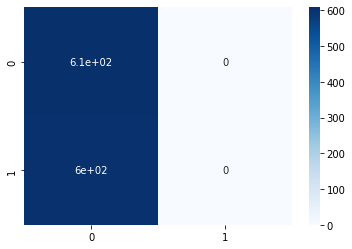

In [355]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_model1)
print(cf_matrix)

sns.heatmap(cf_matrix, annot=True, cmap='Blues')

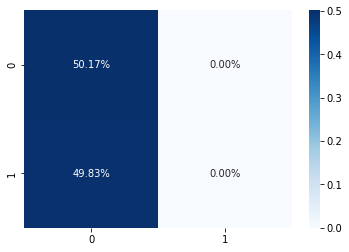

In [359]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')